In [1]:
%%capture

#!pip install numpy==1.17.5
#!pip install -U numpy==1.11.0
!pip3 install numpy==1.17.4

import numpy as np
import pandas as pd 
from tqdm import tqdm

from matplotlib import image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import cv2

!pip install fastai --upgrade

import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

from fastai.vision.all import *

In [2]:
coord_df = pd.read_csv('../input/car-object-detection/data/train_solution_bounding_boxes (1).csv')
coord_df.head(3)

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180


uint8
(380, 676, 3)
473.9826339 172.8523166 602.1389291 231.0505148


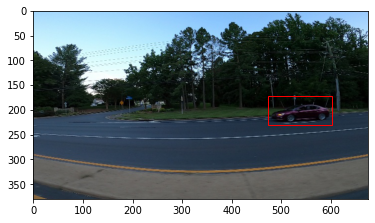

In [3]:
plt_image = image.imread('../input/car-object-detection/data/training_images/vid_4_10480.jpg')

print(plt_image.dtype)
print(plt_image.shape)

fig, ax = plt.subplots()

ax.imshow(plt_image)

xmin = float(coord_df[coord_df["image"] == "vid_4_10480.jpg"]['xmin'])
ymin = float(coord_df[coord_df["image"] == "vid_4_10480.jpg"]['ymin'])
xmax = float(coord_df[coord_df["image"] == "vid_4_10480.jpg"]['xmax'])
ymax = float(coord_df[coord_df["image"] == "vid_4_10480.jpg"]['ymax'])

print(xmin, ymin, xmax, ymax)

rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')

ax.add_patch(rect)

plt.show()

In [4]:
bbox_cols = ['xmin', 'ymin', 'xmax', 'ymax']

def get_target_ds(file_name, df): 
    rows = df[df["image"] == file_name[51:]]  
    bbox = []
    for row in rows[bbox_cols].values:
        bbox_entry = []
        for box in row:
            bbox_entry.append(box)
        bbox.append(bbox_entry)
    return bbox

class CarDetectionDataset(torch.utils.data.Dataset):  
    def __init__(self, images_path, df, std=False):
        super(CarDetectionDataset, self).__init__()
        self.images_path = glob.glob(images_path+"*")
        self.df = df
        self.std = std
        self.bbox_cols = ['xmin', 'ymin', 'xmax', 'ymax']
        
    def __len__(self):
        return len(self.images_path)  

    def __getitem__(self, idx):
        file_path = self.images_path[idx]
        rows = self.df[self.df["image"] == file_path[51:]]
        bbox = rows[self.bbox_cols].values
        
        img = cv2.imread(str(file_path), cv2.IMREAD_UNCHANGED)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        
        #boxes = get_target_ds(img_path, self.df)
        boxes = np.array(bbox)
        bbox[:, 2] = bbox[:, 0] + bbox[:, 2]
        bbox[:, 3] = bbox[:, 1] + bbox[:, 3]
        
        areas = (bbox[:, 3] - bbox[:, 1]) * (bbox[:, 2] - bbox[:, 0])
        bbox = torch.from_numpy(bbox) 
        bbox = torch.as_tensor(bbox, dtype=torch.int64)
        
        if self.std:
            img = img/255.0
            
        img = img.reshape(3, img.shape[0], img.shape[1])
        target = {}
        
        labels = torch.ones((bbox.shape[0]), dtype=torch.int64)            
        
        image_id = torch.tensor([idx])
        
        areas = torch.as_tensor(areas.astype(np.float), dtype=torch.double)
        iscrowd = torch.zeros((boxes.shape[0],))
        
        target["boxes"] = bbox
        target["labels"] = labels
        target["area"] = areas
        target["iscrowd"] = iscrowd
        target["image_id"] = image_id    
        img = torch.from_numpy(img)
        img = torch.as_tensor(img, dtype=torch.double)
        
        return img, target

torch.Size([380, 676, 3]) tensor([[ 125,  187,  391,  423],
        [ 614,  178, 1290,  410]]) tensor([1, 1])


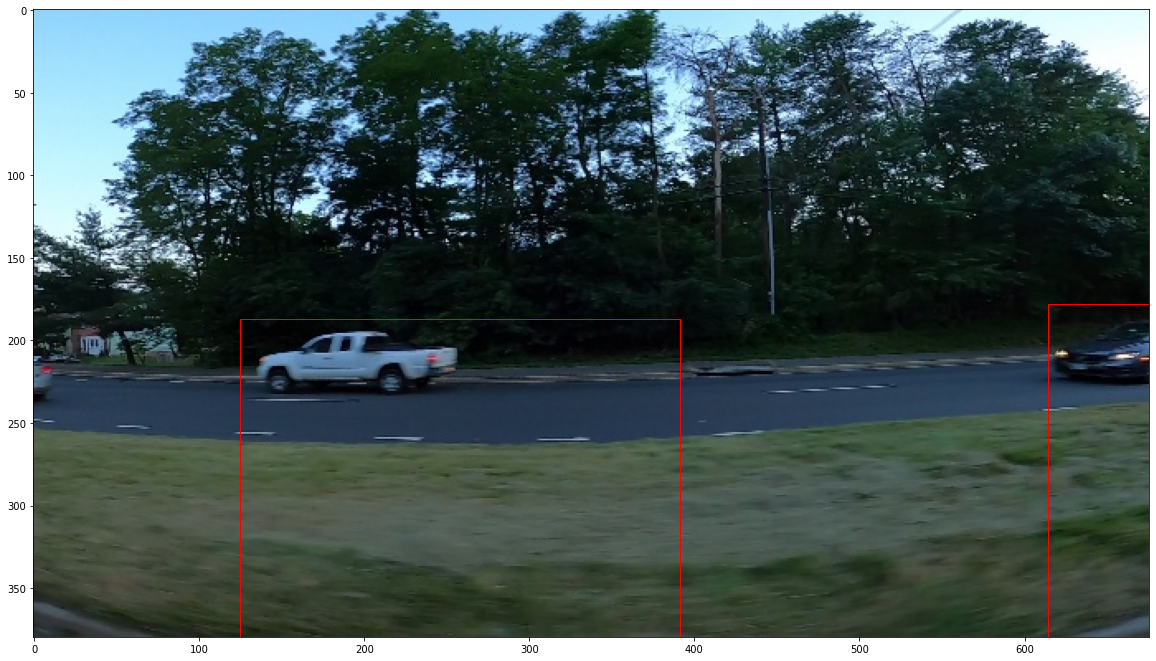

In [5]:
dataset = CarDetectionDataset("../input/car-object-detection/data/training_images/", coord_df)
img, target = dataset.__getitem__(300)
img = img.reshape(img.shape[1], img.shape[2], 3)
img = torch.as_tensor(img, dtype=torch.int)
print(img.shape, target["boxes"], target["labels"])

fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(img)
rect = patches.Rectangle((125, 187), 391-125, 423-187, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
rect = patches.Rectangle((614, 178), 1290-614, 410-178, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

plt.show()

In [6]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset = CarDetectionDataset("../input/car-object-detection/data/training_images/", coord_df, std=True)

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
train_dataset = torch.utils.data.Subset(dataset, indices[:-300])
val_dataset = torch.utils.data.Subset(dataset, indices[-300:])

# define training and validation data loaders
train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=4, shuffle=True, num_workers=0,
        collate_fn = collate_fn)

val_dataloader = torch.utils.data.DataLoader(
        val_dataset, batch_size=1, shuffle=False, num_workers=0,
        collate_fn = collate_fn)

In [7]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print("Device:", device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print("Device:", device)

Device: cuda Tesla P100-PCIE-16GB


In [8]:
%%sh
if [ ! -d "output/vision" ]; then
    git clone https://github.com/pytorch/vision.git output/vision
else
    echo "output/vision already cloned"
fi

cp output/vision/references/detection/utils.py .
cp output/vision/references/detection/transforms.py .
cp output/vision/references/detection/coco_eval.py .
cp output/vision/references/detection/engine.py .
cp output/vision/references/detection/coco_utils.py .

Cloning into 'output/vision'...


In [9]:
%%capture
!pip3 install pycocotools
!pip3 install -U scikit-image
!pip3 install -U cython 

In [16]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

fasterRCNN_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = fasterRCNN_model.roi_heads.box_predictor.cls_score.in_features
fasterRCNN_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

In [14]:
class LossAverager:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [17]:
from engine import train_one_epoch, evaluate
import time

train_loss_hist = LossAverager()
val_loss_hist = LossAverager()
EPOCHS = 10

fasterRCNN_model.double()
fasterRCNN_model.to(device)

params = [p for p in fasterRCNN_model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.0005)#, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)


for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    start_time = time.time()
    fasterRCNN_model.train()
    train_loss_hist.reset()
    
    for images, targets in tqdm(train_dataloader):
        
        images = torch.stack(images).to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        bs = images.shape[0]
        
        loss_dict = fasterRCNN_model(images, targets)
        
        totalLoss = sum(loss for loss in loss_dict.values())
        lossValue = totalLoss.item()
        
        train_loss_hist.update(lossValue,bs)

        optimizer.zero_grad()
        totalLoss.backward()
        optimizer.step()
        lr_scheduler.step(totalLoss)
        
    print(f"Train loss: {train_loss_hist.avg}")
    !rm -rf ./output/
    evaluate(fasterRCNN_model, val_dataloader, device=device)

Epoch 1/10


100%|██████████| 176/176 [05:19<00:00,  1.82s/it]


Train loss: 0.06000669031561096
creating index...
index created!
Test:  [  0/300]  eta: 0:01:13  model_time: 0.2341 (0.2341)  evaluator_time: 0.0014 (0.0014)  time: 0.2446  data: 0.0073  max mem: 12657
Test:  [100/300]  eta: 0:00:46  model_time: 0.2224 (0.2228)  evaluator_time: 0.0012 (0.0012)  time: 0.2336  data: 0.0083  max mem: 12657
Test:  [200/300]  eta: 0:00:23  model_time: 0.2226 (0.2230)  evaluator_time: 0.0010 (0.0012)  time: 0.2341  data: 0.0086  max mem: 12657
Test:  [299/300]  eta: 0:00:00  model_time: 0.2228 (0.2231)  evaluator_time: 0.0010 (0.0012)  time: 0.2343  data: 0.0087  max mem: 12657
Test: Total time: 0:01:10 (0.2349 s / it)
Averaged stats: model_time: 0.2228 (0.2231)  evaluator_time: 0.0010 (0.0012)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.75    

100%|██████████| 176/176 [05:19<00:00,  1.82s/it]


Train loss: 0.03661137138883085
creating index...
index created!
Test:  [  0/300]  eta: 0:01:13  model_time: 0.2338 (0.2338)  evaluator_time: 0.0012 (0.0012)  time: 0.2442  data: 0.0075  max mem: 12657
Test:  [100/300]  eta: 0:00:46  model_time: 0.2225 (0.2230)  evaluator_time: 0.0011 (0.0015)  time: 0.2347  data: 0.0086  max mem: 12657
Test:  [200/300]  eta: 0:00:23  model_time: 0.2231 (0.2233)  evaluator_time: 0.0012 (0.0015)  time: 0.2365  data: 0.0096  max mem: 12657
Test:  [299/300]  eta: 0:00:00  model_time: 0.2228 (0.2233)  evaluator_time: 0.0010 (0.0015)  time: 0.2359  data: 0.0098  max mem: 12657
Test: Total time: 0:01:10 (0.2356 s / it)
Averaged stats: model_time: 0.2228 (0.2233)  evaluator_time: 0.0010 (0.0015)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.75    

100%|██████████| 176/176 [05:20<00:00,  1.82s/it]


Train loss: 0.04599487375649909
creating index...
index created!
Test:  [  0/300]  eta: 0:01:12  model_time: 0.2314 (0.2314)  evaluator_time: 0.0014 (0.0014)  time: 0.2419  data: 0.0075  max mem: 12657
Test:  [100/300]  eta: 0:00:47  model_time: 0.2223 (0.2227)  evaluator_time: 0.0016 (0.0022)  time: 0.2362  data: 0.0093  max mem: 12657
Test:  [200/300]  eta: 0:00:23  model_time: 0.2223 (0.2226)  evaluator_time: 0.0011 (0.0021)  time: 0.2357  data: 0.0095  max mem: 12657
Test:  [299/300]  eta: 0:00:00  model_time: 0.2220 (0.2226)  evaluator_time: 0.0011 (0.0021)  time: 0.2335  data: 0.0085  max mem: 12657
Test: Total time: 0:01:10 (0.2352 s / it)
Averaged stats: model_time: 0.2220 (0.2226)  evaluator_time: 0.0011 (0.0021)
Accumulating evaluation results...
DONE (t=0.09s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.75    

100%|██████████| 176/176 [05:20<00:00,  1.82s/it]


Train loss: 0.03735908302220171
creating index...
index created!
Test:  [  0/300]  eta: 0:01:12  model_time: 0.2309 (0.2309)  evaluator_time: 0.0013 (0.0013)  time: 0.2411  data: 0.0072  max mem: 12657
Test:  [100/300]  eta: 0:00:46  model_time: 0.2220 (0.2223)  evaluator_time: 0.0016 (0.0015)  time: 0.2345  data: 0.0087  max mem: 12657
Test:  [200/300]  eta: 0:00:23  model_time: 0.2221 (0.2226)  evaluator_time: 0.0011 (0.0015)  time: 0.2340  data: 0.0088  max mem: 12657
Test:  [299/300]  eta: 0:00:00  model_time: 0.2225 (0.2227)  evaluator_time: 0.0011 (0.0015)  time: 0.2354  data: 0.0095  max mem: 12657
Test: Total time: 0:01:10 (0.2348 s / it)
Averaged stats: model_time: 0.2225 (0.2227)  evaluator_time: 0.0011 (0.0015)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.75    

100%|██████████| 176/176 [05:19<00:00,  1.82s/it]


Train loss: 0.03370200243989845
creating index...
index created!
Test:  [  0/300]  eta: 0:01:12  model_time: 0.2297 (0.2297)  evaluator_time: 0.0013 (0.0013)  time: 0.2402  data: 0.0075  max mem: 12657
Test:  [100/300]  eta: 0:00:46  model_time: 0.2225 (0.2225)  evaluator_time: 0.0016 (0.0019)  time: 0.2363  data: 0.0094  max mem: 12657
Test:  [200/300]  eta: 0:00:23  model_time: 0.2223 (0.2227)  evaluator_time: 0.0011 (0.0018)  time: 0.2345  data: 0.0087  max mem: 12657
Test:  [299/300]  eta: 0:00:00  model_time: 0.2228 (0.2228)  evaluator_time: 0.0011 (0.0018)  time: 0.2346  data: 0.0089  max mem: 12657
Test: Total time: 0:01:10 (0.2351 s / it)
Averaged stats: model_time: 0.2228 (0.2228)  evaluator_time: 0.0011 (0.0018)
Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.75    

100%|██████████| 176/176 [05:19<00:00,  1.82s/it]


Train loss: 0.03480655549931738
creating index...
index created!
Test:  [  0/300]  eta: 0:01:12  model_time: 0.2300 (0.2300)  evaluator_time: 0.0012 (0.0012)  time: 0.2408  data: 0.0080  max mem: 12658
Test:  [100/300]  eta: 0:00:46  model_time: 0.2222 (0.2228)  evaluator_time: 0.0011 (0.0014)  time: 0.2336  data: 0.0084  max mem: 12658
Test:  [200/300]  eta: 0:00:23  model_time: 0.2224 (0.2229)  evaluator_time: 0.0011 (0.0014)  time: 0.2354  data: 0.0096  max mem: 12658
Test:  [299/300]  eta: 0:00:00  model_time: 0.2224 (0.2228)  evaluator_time: 0.0011 (0.0014)  time: 0.2347  data: 0.0091  max mem: 12658
Test: Total time: 0:01:10 (0.2348 s / it)
Averaged stats: model_time: 0.2224 (0.2228)  evaluator_time: 0.0011 (0.0014)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.75    

100%|██████████| 176/176 [05:19<00:00,  1.82s/it]


Train loss: 0.035665826049905175
creating index...
index created!
Test:  [  0/300]  eta: 0:01:12  model_time: 0.2320 (0.2320)  evaluator_time: 0.0016 (0.0016)  time: 0.2429  data: 0.0076  max mem: 12658
Test:  [100/300]  eta: 0:00:47  model_time: 0.2221 (0.2224)  evaluator_time: 0.0018 (0.0029)  time: 0.2360  data: 0.0088  max mem: 12658
Test:  [200/300]  eta: 0:00:23  model_time: 0.2227 (0.2226)  evaluator_time: 0.0018 (0.0028)  time: 0.2407  data: 0.0115  max mem: 12658
Test:  [299/300]  eta: 0:00:00  model_time: 0.2223 (0.2225)  evaluator_time: 0.0013 (0.0027)  time: 0.2356  data: 0.0095  max mem: 12658
Test: Total time: 0:01:10 (0.2358 s / it)
Averaged stats: model_time: 0.2223 (0.2225)  evaluator_time: 0.0013 (0.0027)
Accumulating evaluation results...
DONE (t=0.12s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.75   

100%|██████████| 176/176 [05:20<00:00,  1.82s/it]


Train loss: 0.03796355252997672
creating index...
index created!
Test:  [  0/300]  eta: 0:01:12  model_time: 0.2325 (0.2325)  evaluator_time: 0.0012 (0.0012)  time: 0.2425  data: 0.0072  max mem: 12658
Test:  [100/300]  eta: 0:00:46  model_time: 0.2225 (0.2225)  evaluator_time: 0.0014 (0.0014)  time: 0.2346  data: 0.0088  max mem: 12658
Test:  [200/300]  eta: 0:00:23  model_time: 0.2222 (0.2228)  evaluator_time: 0.0011 (0.0014)  time: 0.2334  data: 0.0085  max mem: 12658
Test:  [299/300]  eta: 0:00:00  model_time: 0.2223 (0.2227)  evaluator_time: 0.0010 (0.0014)  time: 0.2331  data: 0.0084  max mem: 12658
Test: Total time: 0:01:10 (0.2346 s / it)
Averaged stats: model_time: 0.2223 (0.2227)  evaluator_time: 0.0010 (0.0014)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.75    

100%|██████████| 176/176 [05:19<00:00,  1.82s/it]


Train loss: 0.037219077414403286
creating index...
index created!
Test:  [  0/300]  eta: 0:01:14  model_time: 0.2364 (0.2364)  evaluator_time: 0.0013 (0.0013)  time: 0.2481  data: 0.0087  max mem: 12658
Test:  [100/300]  eta: 0:00:47  model_time: 0.2226 (0.2230)  evaluator_time: 0.0015 (0.0021)  time: 0.2349  data: 0.0085  max mem: 12658


KeyboardInterrupt: 

In [18]:
fasterRCNN_model.eval()
!rm -rf ./output/
evaluate(fasterRCNN_model, val_dataloader, device=device)

creating index...
index created!
Test:  [  0/300]  eta: 0:01:12  model_time: 0.2309 (0.2309)  evaluator_time: 0.0011 (0.0011)  time: 0.2406  data: 0.0070  max mem: 12658
Test:  [100/300]  eta: 0:00:47  model_time: 0.2226 (0.2229)  evaluator_time: 0.0017 (0.0019)  time: 0.2360  data: 0.0091  max mem: 12658
Test:  [200/300]  eta: 0:00:23  model_time: 0.2228 (0.2229)  evaluator_time: 0.0011 (0.0018)  time: 0.2354  data: 0.0091  max mem: 12658
Test:  [299/300]  eta: 0:00:00  model_time: 0.2222 (0.2230)  evaluator_time: 0.0011 (0.0018)  time: 0.2336  data: 0.0085  max mem: 12658
Test: Total time: 0:01:10 (0.2353 s / it)
Averaged stats: model_time: 0.2222 (0.2230)  evaluator_time: 0.0011 (0.0018)
Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.034
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] 

In [23]:
images = cv2.imread("../input/car-object-detection/data/testing_images/vid_5_26640.jpg", cv2.IMREAD_COLOR)
images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
images = torch.as_tensor(images.astype(np.float), dtype=torch.double)
images /= 255.0

cpu_device = torch.device("cpu")

sample = images
images = torch.tensor(images)
images = images.permute(2,0,1)
images = torch.unsqueeze(images, 0)
images = images.to(cpu_device)
fasterRCNN_model.eval()

fasterRCNN_model.to(cpu_device)
outputs = fasterRCNN_model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
boxes = outputs[0]["boxes"].detach().numpy().astype(np.int32)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


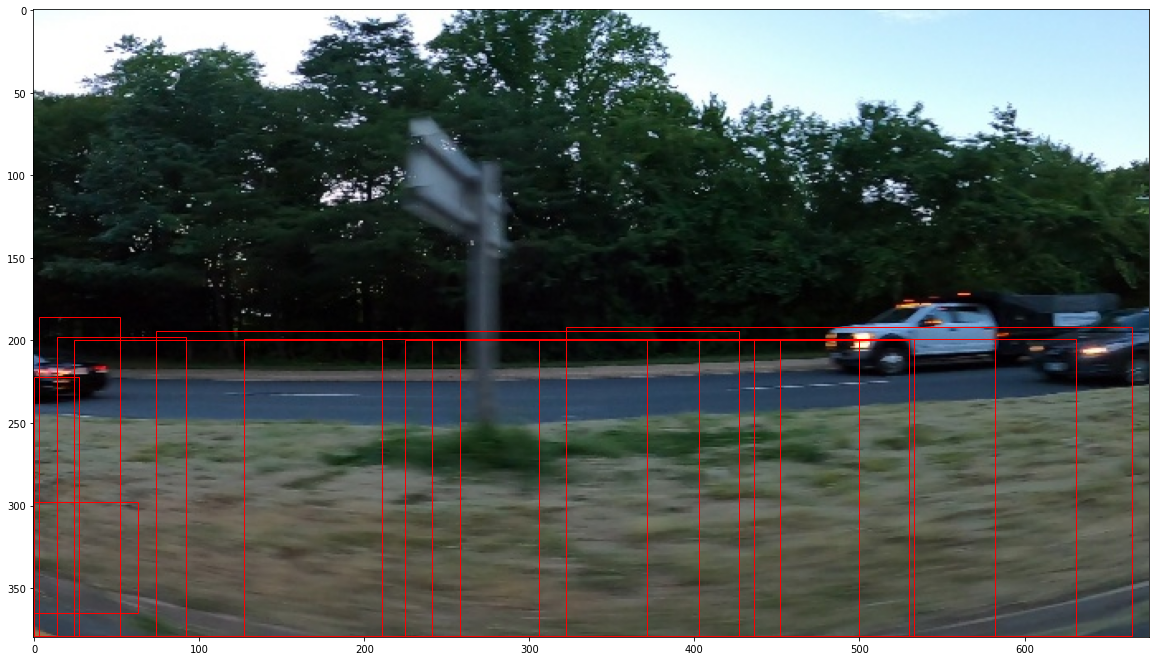

In [28]:
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(sample)
for box in boxes:
    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()